In [4]:
from google.colab import files
files.upload()  # upload kaggle.json here



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annanyasharma22","key":"cddc70b70370c7a8439db440b3767e50"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 97% 2.23G/2.29G [00:16<00:01, 40.3MB/s]
100% 2.29G/2.29G [00:16<00:00, 149MB/s] 


In [7]:
train_dir = "/content/chest_xray/train"
val_dir = "/content/chest_xray/val"
test_dir = "/content/chest_xray/test"


In [8]:
!unzip chest-xray-pneumonia.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg  


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, DenseNet121, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, os, random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE

import cv2


In [12]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5   # we will do small epochs since you are in time crunch

train_dir = "/content/chest_xray/train"
val_dir   = "/content/chest_xray/val"
test_dir  = "/content/chest_xray/test"

class_names = ["Normal", "Pneumonia"]


In [13]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_test_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_data = val_test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


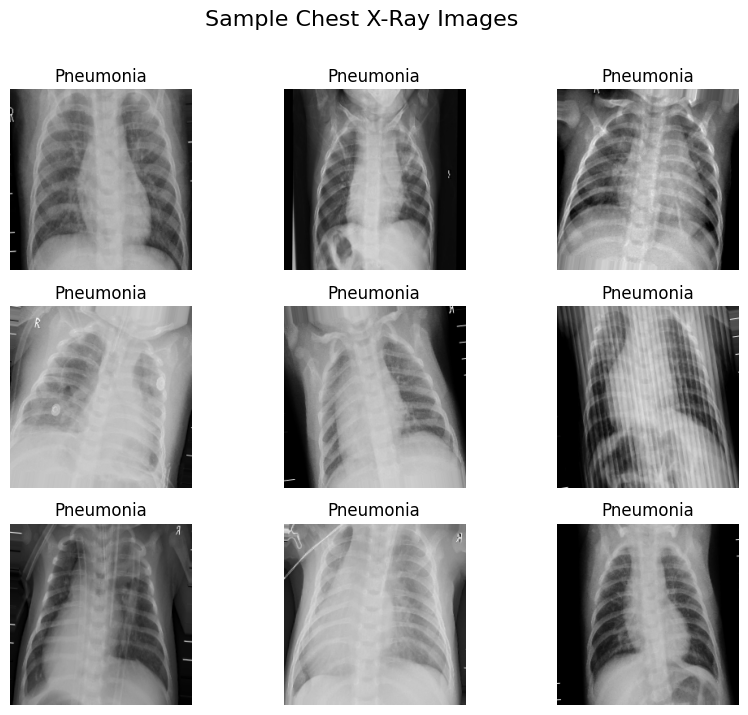

In [9]:
import matplotlib.pyplot as plt

def show_sample_images(data, class_names):
    x, y = next(data)
    plt.figure(figsize=(10, 8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(x[i], cmap='gray')
        plt.title(class_names[int(y[i])])
        plt.axis('off')
    plt.suptitle("Sample Chest X-Ray Images", fontsize=16)
    plt.show()

show_sample_images(train_data, class_names)


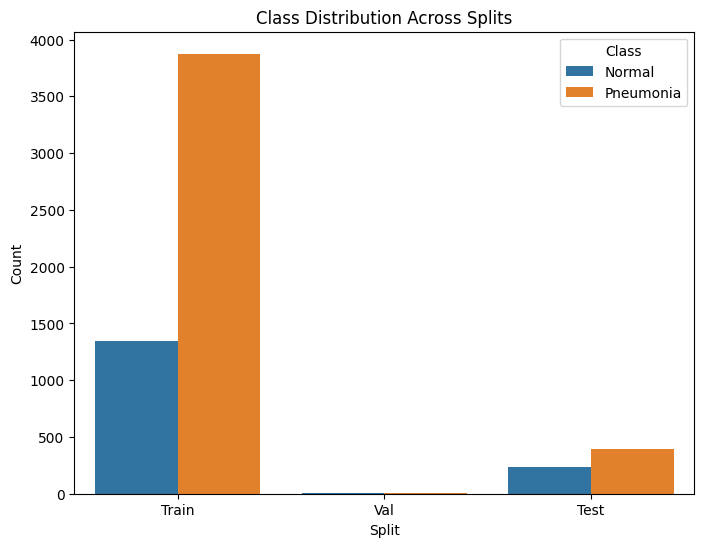

In [10]:
import os
import seaborn as sns

def count_images(folder):
    normal = len(os.listdir(os.path.join(folder, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(folder, "PNEUMONIA")))
    return normal, pneumonia

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

df_counts = pd.DataFrame({
    "Split": ["Train","Train","Val","Val","Test","Test"],
    "Class": ["Normal","Pneumonia","Normal","Pneumonia","Normal","Pneumonia"],
    "Count": [train_counts[0], train_counts[1],
              val_counts[0], val_counts[1],
              test_counts[0], test_counts[1]]
})

plt.figure(figsize=(8,6))
sns.barplot(data=df_counts, x="Split", y="Count", hue="Class")
plt.title("Class Distribution Across Splits")
plt.show()


In [11]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    preds = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=preds)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [12]:
models_dict = {
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "EfficientNetB0": EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "DenseNet121": DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
}


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
results = []

for name, base in models_dict.items():
    print(f"\n🔵 Training {name}...\n")

    model = build_model(base)

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=5,
        verbose=1
    )

    # Evaluation
    start = time.time()
    preds = model.predict(test_data)
    infer_time = time.time() - start

    preds_bin = (preds > 0.5).astype(int)
    y_true = test_data.classes

    report = classification_report(y_true, preds_bin, output_dict=True)
    cm = confusion_matrix(y_true, preds_bin)

    results.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1": report["1"]["f1-score"],
        "Inference Time": infer_time,
        "Params": model.count_params()
    })

    # Save model
    model.save(f"{name}_pneumonia.h5")

pd.DataFrame(results)



🔵 Training MobileNetV2...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 674ms/step - accuracy: 0.9115 - loss: 0.2069 - val_accuracy: 0.5000 - val_loss: 1.4821
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 586ms/step - accuracy: 0.9715 - loss: 0.0802 - val_accuracy: 0.5625 - val_loss: 1.0468
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.9841 - loss: 0.0492 - val_accuracy: 0.7500 - val_loss: 0.5274
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 594ms/step - accuracy: 0.9843 - loss: 0.0387 - val_accuracy: 0.5000 - val_loss: 2.4673
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.9911 - loss: 0.0233 - val_accuracy: 0.5625 - val_loss: 1.1516
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step



🔵 Training EfficientNetB0...

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 652ms/step - accuracy: 0.9055 - loss: 0.2854 - val_accuracy: 0.5000 - val_loss: 0.7004
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 597ms/step - accuracy: 0.9662 - loss: 0.0885 - val_accuracy: 0.5000 - val_loss: 0.8227
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 604ms/step - accuracy: 0.9760 - loss: 0.0677 - val_accuracy: 0.6875 - val_loss: 0.5721
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.9817 - loss: 0.0496 - val_accuracy: 0.5000 - val_loss: 0.8259
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 598ms/step - accuracy: 0.9805 - loss: 0.0470 - val_accuracy: 0.5000 - val_loss: 1.0336
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 529ms/step



🔵 Training DenseNet121...

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 294s 749ms/step - accuracy: 0.8958 - loss: 0.2473 - val_accuracy: 0.5000 - val_loss: 1.1936
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 659ms/step - accuracy: 0.9782 - loss: 0.0558 - val_accuracy: 0.7500 - val_loss: 0.8790
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 663ms/step - accuracy: 0.9846 - loss: 0.0399 - val_accuracy: 0.8125 - val_loss: 0.8014
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 658ms/step - accuracy: 0.9903 - loss: 0.0323 - val_accuracy: 1.0000 - val_loss: 0.0209
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 655ms/step - accuracy: 0.9882 - loss: 0.0312 - val_accuracy: 0.8125 - val_loss: 0.2862
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 786ms/step



🔵 Training ResNet50...

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 172s 689ms/step - accuracy: 0.9094 - loss: 0.1896 - val_accuracy: 0.5000 - val_loss: 3.4717
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 656ms/step - accuracy: 0.9765 - loss: 0.0621 - val_accuracy: 0.5000 - val_loss: 2.9755
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 662ms/step - accuracy: 0.9870 - loss: 0.0409 - val_accuracy: 0.5000 - val_loss: 3.6212
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 663ms/step - accuracy: 0.9911 - loss: 0.0241 - val_accuracy: 0.5000 - val_loss: 6.5187
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 659ms/step - accuracy: 0.9921 - loss: 0.0257 - val_accuracy: 0.5000 - val_loss: 2.1747
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,F1,Inference Time,Params
0,MobileNetV2,0.655449,0.644628,1.000000,0.783920,21.420437,2259265
1,EfficientNetB0,0.623397,0.624799,0.994872,0.767557,18.323613,4050852
2,DenseNet121,0.804487,0.763780,0.994872,0.864143,27.869889,7038529
3,ResNet50,0.625000,0.625000,1.000000,0.769231,13.044144,23589761


from matplotlib import pyplot as plt
_df_0['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['F1'].plot(kind='hist', bins=20, title='F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Recall', y='F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='F1', y='Inference Time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Inference Time']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Inference Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Inference Time')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Inference Time']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Inference Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Inference Time')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Inference Time']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Inference Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Inference Time')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Inference Time']
  ys = series['F1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Inference Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Inference Time')
_ = plt.ylabel('F1')

from matplotlib import pyplot as plt
_df_13['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['F1'].plot(kind='line', figsize=(8, 4), title='F1')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='F1', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [14]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/Pneumonia_CNN_Backup/"

# Copy all .h5 models
!cp *.h5 "/content/drive/MyDrive/Pneumonia_CNN_Backup/"

# Save results dataframe
import pandas as pd
df_results = pd.DataFrame(results)
df_results.to_csv("/content/drive/MyDrive/Pneumonia_CNN_Backup/model_results.csv", index=False)

print("✅ Backup completed — models & results saved in Drive")


Mounted at /content/drive
✅ Backup completed — models & results saved in Drive


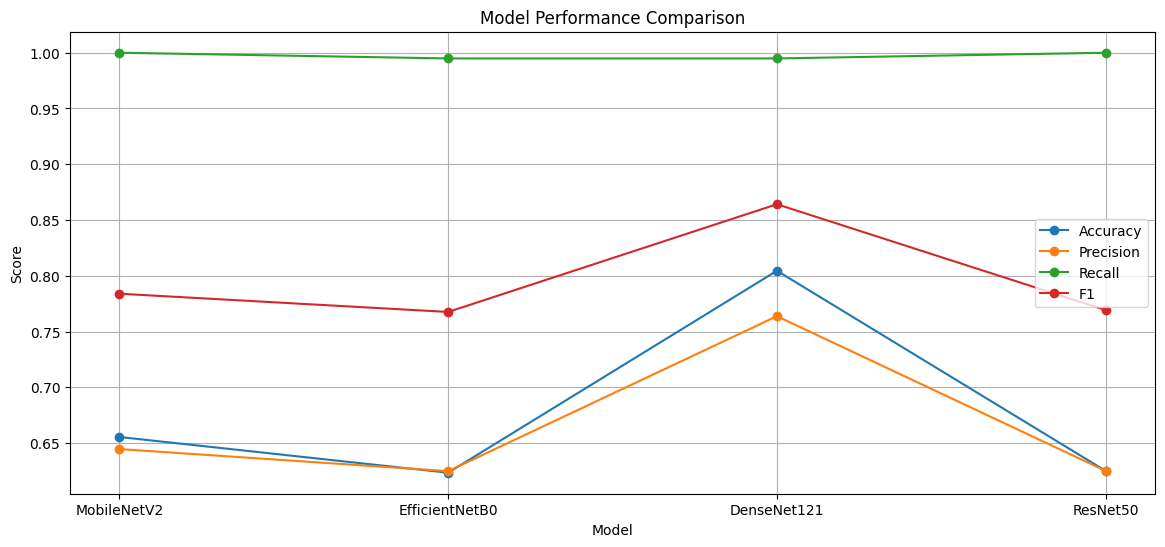

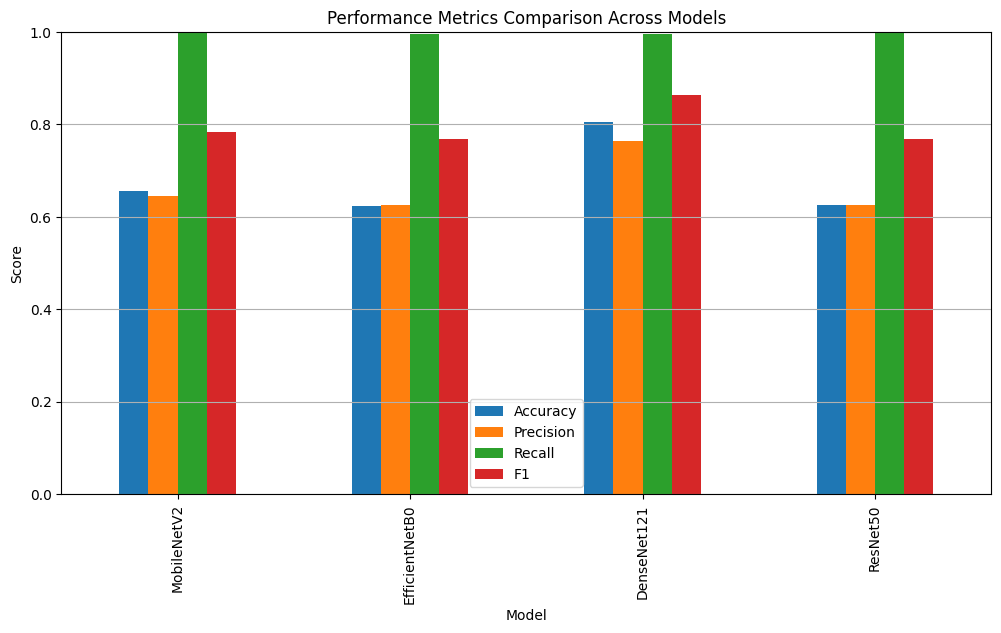

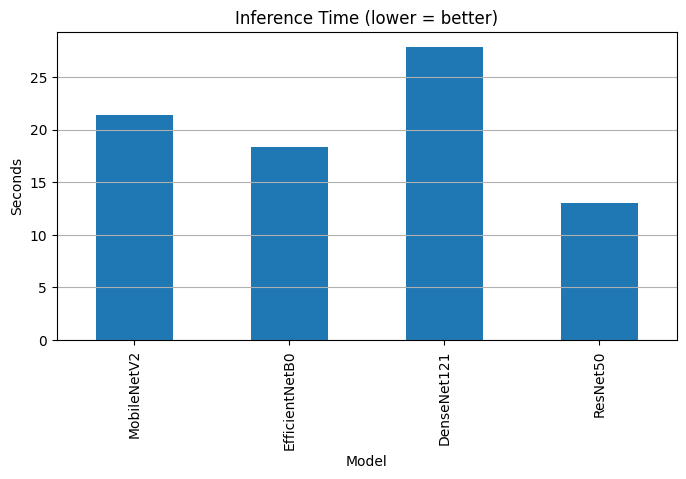

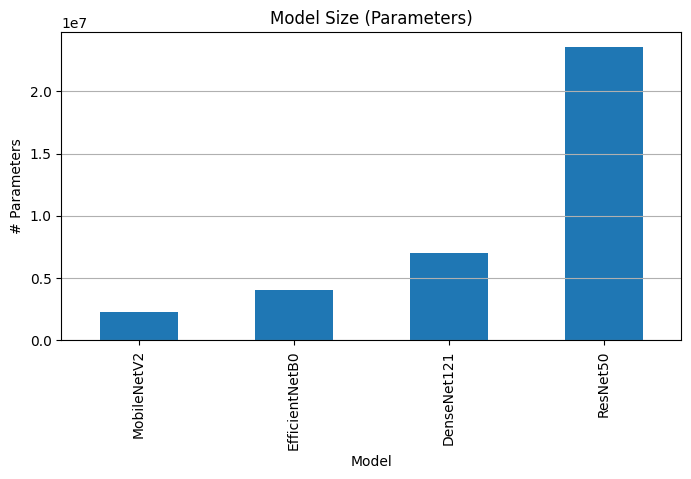

In [26]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1"]

plt.figure(figsize=(14,6))
for m in metrics:
    plt.plot(df_results["Model"], df_results[m], marker="o", label=m)

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

df_results.set_index("Model")[["Accuracy","Precision","Recall","F1"]].plot(kind="bar", figsize=(12,6))
plt.title("Performance Metrics Comparison Across Models")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y")
plt.show()

df_results.set_index("Model")["Inference Time"].plot(kind="bar", figsize=(8,4))
plt.title("Inference Time (lower = better)")
plt.ylabel("Seconds")
plt.grid(axis="y")
plt.show()

df_results.set_index("Model")["Params"].plot(kind="bar", figsize=(8,4))
plt.title("Model Size (Parameters)")
plt.ylabel("# Parameters")
plt.grid(axis="y")
plt.show()



In [2]:
from google.colab import drive
drive.mount('/content/drive')

# copy back models if needed
!cp "/content/drive/MyDrive/Pneumonia_CNN_Backup/*.h5" .


Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/Pneumonia_CNN_Backup/*.h5': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Reload model base
base = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

print("✅ DenseNet121 Rebuild Complete. Training short session...")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2,
    verbose=1
)


✅ DenseNet121 Rebuild Complete. Training short session...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 706ms/step - accuracy: 0.5996 - loss: 0.7134 - val_accuracy: 0.5000 - val_loss: 1.0299
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.7218 - loss: 0.5648 - val_accuracy: 0.5000 - val_loss: 0.9383


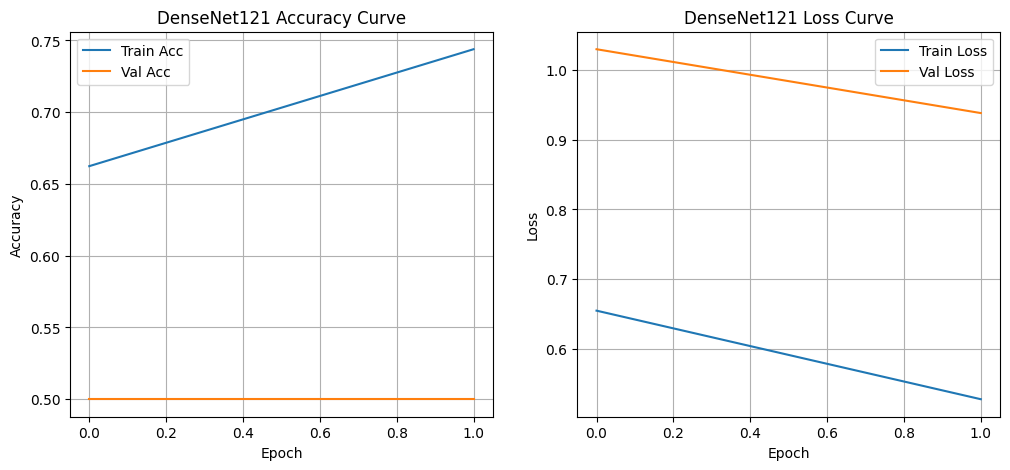

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("DenseNet121 Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("DenseNet121 Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step


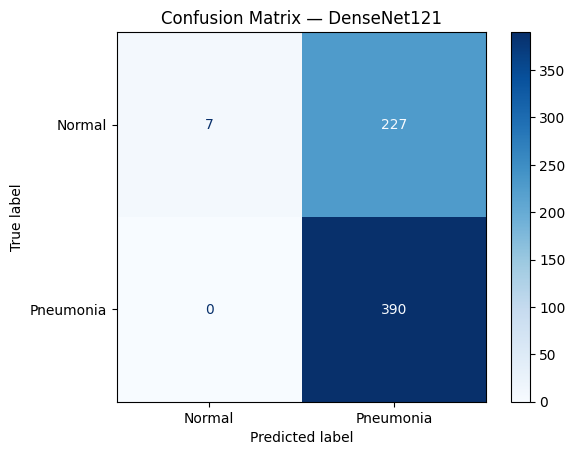

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — DenseNet121")
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step


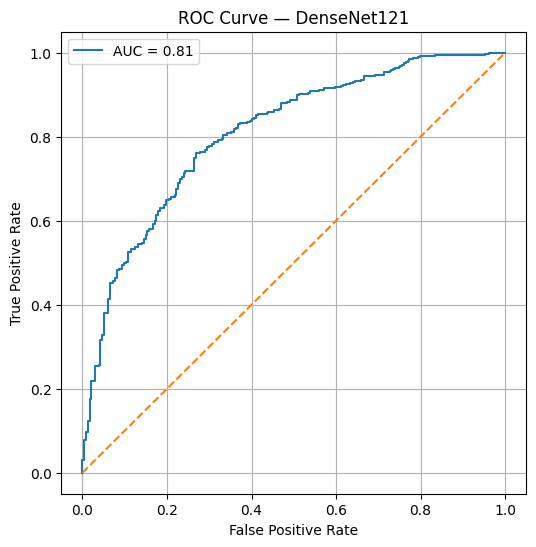

In [18]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict(test_data)
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve — DenseNet121")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_densenet.h5", save_best_only=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight={0: 1.5, 1: 1},  # Reduce bias towards Pneumonia
    callbacks=callbacks
)


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.7859 - loss: 0.5771

163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 627ms/step - accuracy: 0.7860 - loss: 0.5768 - val_accuracy: 0.5625 - val_loss: 0.7372
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8313 - loss: 0.4854

163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 633ms/step - accuracy: 0.8313 - loss: 0.4853 - val_accuracy: 0.5625 - val_loss: 0.6736
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8542 - loss: 0.4427

163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.8543 - loss: 0.4425 - val_accuracy: 0.6250 - val_loss: 0.6360
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.8757 - loss: 0.4001

163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 624ms/step - accuracy: 0.8757 - loss: 0.4001 - val_accuracy: 0.6250 - val_loss: 0.5824
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.8852 - loss: 0.3648 - val_accuracy: 0.6250 - val_loss: 0.5942
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8923 - loss: 0.3424

163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.8923 - loss: 0.3424 - val_accuracy: 0.6250 - val_loss: 0.5445
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.8927 - loss: 0.3256 - val_accuracy: 0.6250 - val_loss: 0.5539
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8972 - loss: 0.3222

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.8972 - loss: 0.3221 - val_accuracy: 0.6875 - val_loss: 0.5178
Epoch 9/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9137 - loss: 0.2947

163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.9136 - loss: 0.2947 - val_accuracy: 0.6875 - val_loss: 0.5119
Epoch 10/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.9110 - loss: 0.2881

163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.9110 - loss: 0.2881 - val_accuracy: 0.6875 - val_loss: 0.5064
Epoch 11/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9145 - loss: 0.2710

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - accuracy: 0.9145 - loss: 0.2710 - val_accuracy: 0.6875 - val_loss: 0.5063
Epoch 12/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9096 - loss: 0.2846

163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 616ms/step - accuracy: 0.9096 - loss: 0.2846 - val_accuracy: 0.6875 - val_loss: 0.4864
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 628ms/step - accuracy: 0.9199 - loss: 0.2567 - val_accuracy: 0.6875 - val_loss: 0.4924
Epoch 14/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 612ms/step - accuracy: 0.9104 - loss: 0.2774 - val_accuracy: 0.6875 - val_loss: 0.5084
Epoch 15/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 621ms/step - accuracy: 0.9171 - loss: 0.2602 - val_accuracy: 0.6875 - val_loss: 0.4874


In [42]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam # Import Adam

model = load_model("best_densenet.h5")

# Explicitly compile the model after loading
model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
from sklearn.metrics import precision_recall_curve

y_scores = model.predict(test_data)
prec, rec, thresholds = precision_recall_curve(y_true, y_scores)

best_thresh = thresholds[ (prec*rec).argmax() ]
print("Best Threshold =", best_thresh)


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 893ms/step
Best Threshold = 0.6916109


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_860']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


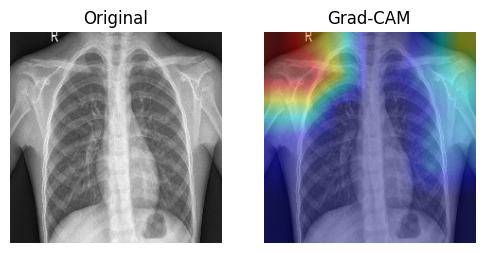

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def grad_cam(img_array, model, layer_name):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:,:,i]

    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def show_gradcam(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0
    img_input = np.expand_dims(img_array, axis=0)

    cam = grad_cam(img_input, model, "conv5_block16_concat")
    cam = cv2.resize(cam, (224,224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(np.uint8(img_array*255), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img_array); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM"); plt.axis("off")
    plt.show()

# Show a sample X-ray
test_img = test_data.filepaths[0]
show_gradcam(test_img)


In [23]:
from sklearn.metrics import precision_recall_curve
import numpy as np

y_scores = model.predict(test_data)
prec, rec, thresholds = precision_recall_curve(y_true, y_scores)

best_thresh = thresholds[np.argmax(prec * rec)]
best_thresh


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step


np.float32(0.6916109)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
AUC: 0.9302323033092262
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       234
           1       0.90      0.90      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



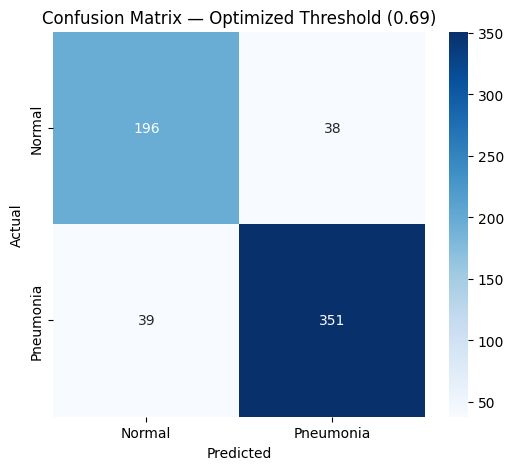

In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
probs = model.predict(test_data)
y_pred = (probs > 0.6916109).astype(int)
y_true = test_data.classes

# Metrics
print("AUC:", roc_auc_score(y_true, probs))
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal','Pneumonia'],
            yticklabels=['Normal','Pneumonia'])
plt.title("Confusion Matrix — Optimized Threshold (0.69)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
)


In [26]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(1e-5), loss="binary_crossentropy", metrics=['accuracy'])

model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    class_weight={0:1.5, 1:1}
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 137s 696ms/step - accuracy: 0.9123 - loss: 0.2751 - val_accuracy: 0.6875 - val_loss: 0.4969
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - accuracy: 0.9137 - loss: 0.2748 - val_accuracy: 0.6875 - val_loss: 0.4991
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9211 - loss: 0.2694 - val_accuracy: 0.6875 - val_loss: 0.4988
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 615ms/step - accuracy: 0.9134 - loss: 0.2784 - val_accuracy: 0.6875 - val_loss: 0.4968
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.9178 - loss: 0.2640 - val_accuracy: 0.6875 - val_loss: 0.4968


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 809ms/step
AUC: 0.9311746657900504
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       234
           1       0.89      0.91      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



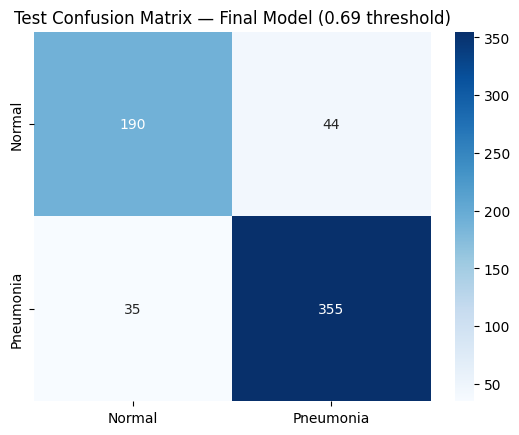

In [27]:
probs = model.predict(test_data)
y_pred = (probs > 0.6916109).astype(int)
y_true = test_data.classes

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("AUC:", roc_auc_score(y_true, probs))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal','Pneumonia'],
            yticklabels=['Normal','Pneumonia'])
plt.title("Test Confusion Matrix — Final Model (0.69 threshold)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


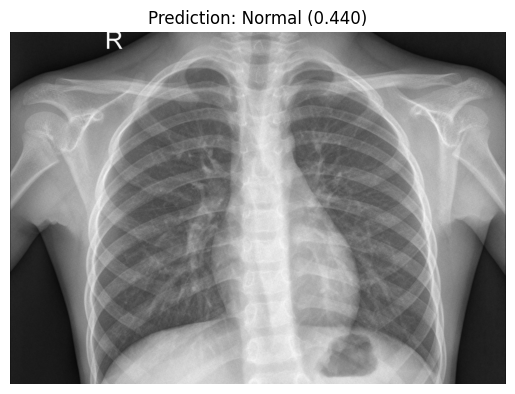

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ---- Load & Preprocess Image ----
img_path = "/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg"  # change path to test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# ---- Prediction ----
pred = model.predict(img_array)[0][0]
threshold = 0.69
pred_class = "Pneumonia" if pred > threshold else "Normal"

# ---- Display ----
plt.imshow(cv2.imread(img_path)[:,:,::-1])
plt.title(f"Prediction: {pred_class} ({pred:.3f})")
plt.axis('off')
plt.show()


In [29]:
import os

test_dir = "/content/chest_xray/test"
correct, total = 0, 0

for label in ["NORMAL", "PNEUMONIA"]:
    folder = os.path.join(test_dir, label)

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        pred = model.predict(img_array)[0][0]
        pred_class = "PNEUMONIA" if pred > 0.69 else "NORMAL"

        if pred_class == label:
            correct += 1

        total += 1

print(f"✅ Test Accuracy: {correct/total:.2%} ({correct}/{total})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


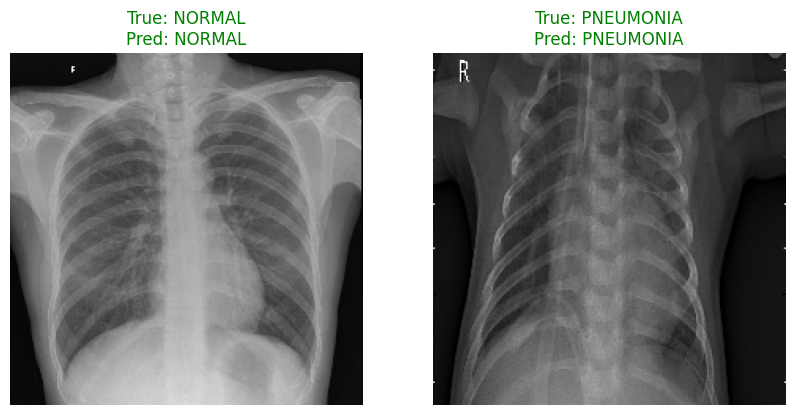

In [30]:
import random

test_root = "/content/chest_xray/test"
images = []

for label in ["NORMAL", "PNEUMONIA"]:
    files = os.listdir(os.path.join(test_root, label))
    sample = random.choice(files)
    images.append((os.path.join(test_root, label, sample), label))

plt.figure(figsize=(10,5))

for i,(img_path,true_label) in enumerate(images):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(image.img_to_array(img), 0) / 255.

    pred = model.predict(img_array)[0][0]
    pred_label = "PNEUMONIA" if pred > 0.69 else "NORMAL"

    plt.subplot(1,2,i+1)
    plt.imshow(img)
    color = "green" if pred_label == true_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.show()


Testing: /content/chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3122']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


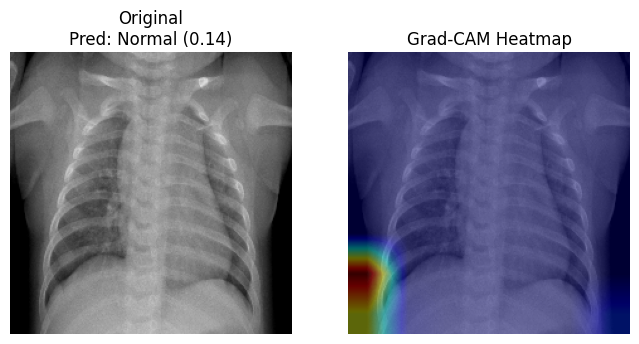

In [47]:
import numpy as np, cv2, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

# ---------------- GRAD-CAM CORE ----------------
def get_gradcam(model, img_array, layer_name="conv5_block16_concat"):
    # Create model that maps input → last conv layer → output
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        loss = preds[:, 0]  # binary output

    grads = tape.gradient(loss, conv_outputs)[0]   # gradients
    conv_outputs = conv_outputs[0]                # conv maps

    # Global average pooling of gradients
    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / (cam.max() + 1e-8)  # normalize
    cam = cv2.resize(cam, (224, 224))

    return cam

# --------------- DISPLAY FUNCTION ----------------
def show_gradcam(img_path, thresh=0.69):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)

    cam = get_gradcam(model, img_input)

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(np.uint8(img_array*255), 0.6, heatmap, 0.4, 0)

    prob = model.predict(img_input)[0][0]
    pred = "Pneumonia" if prob > thresh else "Normal"

    # Plot both images
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img_array)
    plt.title(f"Original\nPred: {pred} ({prob:.2f})")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.show()

# -------------- TEST ON RANDOM IMAGE --------------
import os, random

test_root = "/content/chest_xray/test"
cls = random.choice(["NORMAL", "PNEUMONIA"])
file = random.choice(os.listdir(os.path.join(test_root, cls)))
path = os.path.join(test_root, cls, file)

print("Testing:", path)
show_gradcam(path)


In [39]:
for layer in model.layers:
  print(layer.name)

input_layer_2
zero_padding2d_4
conv1_conv
conv1_bn
conv1_relu
zero_padding2d_5
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv

In [34]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,581 (26.86 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 2,052 (8.02 KB)